In [1]:
# %load C60_jupyter_imports.py
%load_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
from dask.distributed import Client
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import xesmf as xe
from scipy.stats import linregress
import os
import requests
# Lets import our functions. There are no tests here. Stored separately so as to not make a mess.
# Make sure in right dir first

os.chdir('/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/')

In [2]:
# Set up the remote dask cluster
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=2,memory="16GB")
client = Client(cluster)
cluster.scale(cores=8)
#cluster.adapt(minimum=2, maximum=16)
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44775 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/44775/status,
Dashboard: /proxy/44775/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.129:42983,Workers: 0
Dashboard: /proxy/44775/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
raw_land_path='/g/data/xv83/np1383/external_data/co2/landschutzer_co2/spco2_MPI-SOM_FFN_v2020.nc'
raw_roden_path='../../rxm599/obs/oc_v2021_daily.nc'

In [19]:
cluster

In [22]:
land=xr.open_dataset(raw_land_path,chunks={'time':1}).fgco2_smoothed
roden=xr.open_dataset(raw_roden_path,chunks={'time':1}).co2flux_ocean

In [21]:
cafe=xr.open_dataset('/g/data/xv83/np1383/processed_data/cafe/global/stf10_ensmean_1982.nc')
regridder = xe.Regridder(roden, cafe, 'bilinear',reuse_weights=False)
roden_rg=regridder(roden)
roden_rg.to_netcdf('roden_test_rg.nc')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/dask/array/core.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


KeyboardInterrupt: 

In [18]:
regridder = xe.Regridder(roden, land, 'bilinear',reuse_weights=False)
roden_rg=regridder(roden)
roden_rg.to_netcdf('roden_test_rg.nc')

KilledWorker: ("('regrid_array-transpose-store-4accb255-2fba-11ec-88a6-fa163eca8eaa', 0, 0, 0)", <WorkerState 'tcp://10.0.128.6:40819', name: SLURMCluster-2-1, memory: 0, processing: 1>)

In [ ]:
roden_rg=xr.open_dataset('roden_test_rg.nc')

In [23]:
land=xr.open_dataset(raw_land_path,chunks='auto').fgco2_smoothed
roden=xr.open_dataset(raw_roden_path,chunks='auto').co2flux_ocean

In [ ]:
cluster.scale(cores=2)

In [6]:
land

<xarray.DataArray 'fgco2_smoothed' (time: 456, lat: 180, lon: 360)>
[29548800 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1982-01-15 1982-02-15 ... 2019-12-15
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Attributes:
    long_name:      CO2 flux smoothed
    standard_name:  CO2 flux smoothed
    units:          mol/m2/yr
    FillValue:      1e+20

In [7]:
roden

<xarray.DataArray 'co2flux_ocean' (mtime: 23376, lat: 90, lon: 144)>
[302952960 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 -178.8 -176.2 -173.8 -171.2 ... 173.8 176.2 178.8
  * lat      (lat) float32 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * mtime    (mtime) datetime64[ns] 1957-01-01T11:59:59 ... 2020-12-31T12:00:00
Attributes:
    long_name:      Ocean-atmosphere co2 flux
    units:          PgC/yr
    cell_methods:   lon: lat: sum
    cell_measures:  area: dxyp

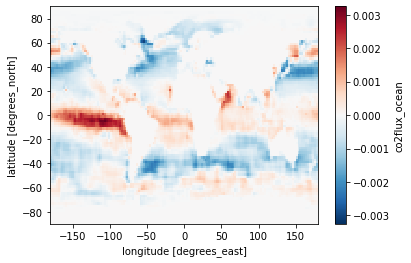

In [10]:
roden.mean(dim='mtime').plot()

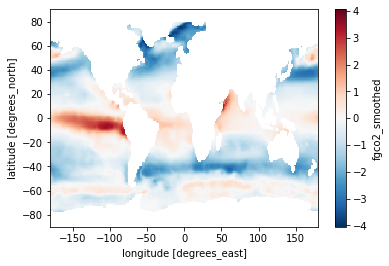

In [12]:
land.mean(dim='time').plot()

In [ ]:
land_dat=land.sel(lat=0,lon=-90,method='nearest').mean(dim='time').values #mol C/m2/yr
roden_dat=roden.sel(lat=0,lon=-90,method='nearest').mean(dim='mtime').values #Pg CO2 /yr/ grid??

In [ ]:
land_dat*12/365 #Should be in gC/m2/day

In [ ]:
roden_dat*1e15/365/(111.1*111.1*1000*1000*5)#gC/m2/day #PgC*1e15 = gC/yr / 365=